# Trabalho Prático 2 - "COVID-19: Incorrect Mask Usage Detection"

Objetivo: Explorar o uso de CNN's (keras) para a deteção do uso incorrecto da máscara cirurgica.

Tipo de tarefa machine learning: Classificação Binária.

Dataset utilizado: [MaskedFace-Net](https://github.com/cabani/MaskedFace-Net)

Repositório: [GitHub](https://www.google.com)

Trabalho realizado por:

* Bruno Silva
* Diogo Silva

In [221]:
!pip install tensorflow
!pip install git+https://github.com/tensorflow/docs
!pip install sklearn
# Limpar output
from IPython.display import clear_output
clear_output()

# Definir constantes úteis 

In [222]:
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use('ggplot')

BATCH_SIZE = 512
IMG_SIZE = (100,100)
SHUFFLE = True

EPOCHS = 25
VERBOSE = 0

# Colocar o IMG_SIZE com uma terceira dimensao
input_shape = IMG_SIZE + (3,)


# 1. Fazer load dos dados

Os nossos dados encontram-se estruturados da seguinte forma:

```
Dataset/
..train/
  ...correct/
  ......00000_Mask.jpg
  ......00001_Mask.jpg
  ...incorrect/
  ......00000_Mask.jpg
  ......00001_Mask.jpg
..test/
  ...correct/
  ......00000_Mask.jpg
  ......00001_Mask.jpg
  ...incorrect/
  ......00000_Mask.jpg
  ......00001_Mask.jpg
..val/
  ...correct/
  ......00000_Mask.jpg
  ......00001_Mask.jpg
  ...incorrect/
  ......00000_Mask.jpg
  ......00001_Mask.jpg
```

Para fazer load dos dados, iremos utilizar a função `image_dataset_from_directory` do [TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory). 

In [223]:
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory

print("Train data:")
# Create train ds
train_ds = image_dataset_from_directory(
    '../input/mask-usage/ReducedDataset/train', 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE, 
    shuffle=SHUFFLE,  
)

print("Validation data:")
# Create val ds
val_ds = image_dataset_from_directory(
    '../input/mask-usage/ReducedDataset/val', 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE, 
    shuffle=SHUFFLE, 
)

print("Test data:")
# Create test ds
test_ds = image_dataset_from_directory(
    '../input/mask-usage/ReducedDataset/test',
    batch_size=BATCH_SIZE,  
    image_size=IMG_SIZE, 
    shuffle=SHUFFLE,
)

Train data:
Found 2608 files belonging to 2 classes.
Validation data:
Found 1904 files belonging to 2 classes.
Test data:
Found 630 files belonging to 2 classes.


# 2. Visualizar os dados

Vamos visualizar as primeiras 9 imagens do dataset de treino. As imagens com a label `1`, correspondem à forma incorreta da utilização da máscara, e a label `0` à correta utilização.
Podemos pelo plot das imagens também confirmar que todas elas se encontram com tamanho fixo `(150, 150)`, e que os valores dos pixeis se encontram no intervalo `[0, 1]`.

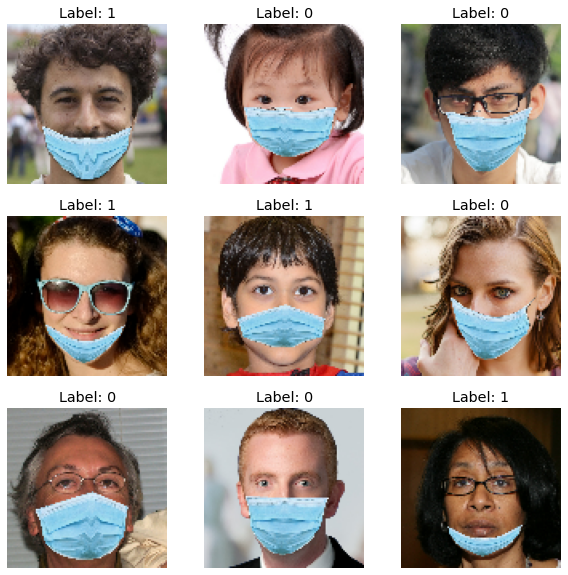

In [224]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")


## 2.1 Otimização dos dados

In [225]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 2.2 Augmentação de dados

Como temos poucos dados disponiveis uma técnica bastante utilizada e com bons resultados é a augmentação de dados.

In [226]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"), # "espelho" horizontal
  layers.experimental.preprocessing.RandomRotation(0.2), # [-20% * 2pi, 20% * 2pi]
])

Abaixo podemos observar o tipo de transformações que uma imagem irá sofrer.

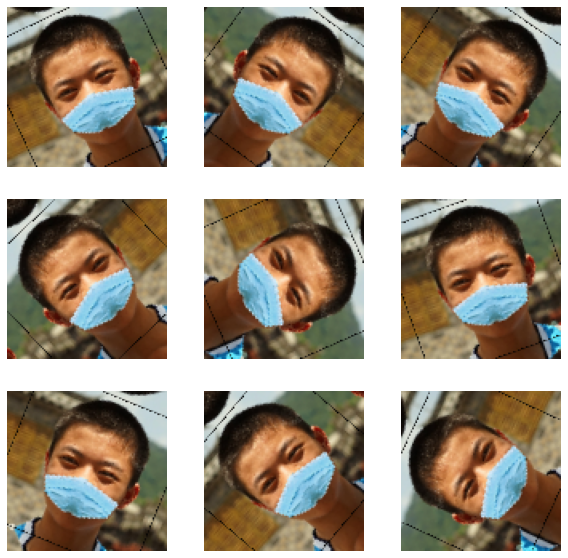

In [227]:
import matplotlib.pyplot as plt

images, _ = next(iter(train_ds))

first_image = images[0]

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis('off')




## 2.3 Reescalonamento dos dados

In [228]:
from tensorflow.keras import layers
data_scaling = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1), # entre [-1,1]
])

# 3. Construir modelos

## 3.1 Testar diferentes activações ('tanh', 'sigmoid', 'relu', 'leakyrelu')

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

history={}
for activation in ['tanh', 'sigmoid', 'relu']:
    model = Sequential([
            # Input
            layers.InputLayer(input_shape=input_shape),

            # Augmentação de dados
            data_augmentation,

            # Rescale dos dados
            data_scaling,

            # Camadas convolucionais
            layers.Conv2D(16, 3, padding='same', activation=activation),
            layers.MaxPooling2D(),

            # Classificação
            layers.Flatten(),
            layers.Dense(128, activation=activation),
            layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(), )


    history[f"{activation.capitalize()}"] = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose = VERBOSE
    )


# Criar plotter
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
# Fazemos plot do historico de treino
plotter.plot(history)

Como podemos ver pelo gráfico acima a função de ativação `relu` leva a uma convergência mais rápida. De seguida iremos comparar o seu desempenho com a função `LeakyRelu`

In [ ]:
model = Sequential([
        # Input
        layers.InputLayer(input_shape=input_shape),

        # Augmentação de dados
        data_augmentation,

        # Rescale dos dados
        data_scaling,

        # Camadas convolucionais
        layers.Conv2D(16, 3, padding='same'),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(),

        # Classificação
        layers.Flatten(),
        layers.Dense(128),
        
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(), )


history["LeakyRelu"] = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose = VERBOSE
)
# Fazemos novo plot do historico de treino
plotter.plot(history)

Como podemos observar a função de ativação `LeakyRelu` parece ter o desempenho superior. Iremos utilizar esta função nas próximas experiências.

## 3.2 Testar diferentes optimizadores

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential


from tensorflow.keras import optimizers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

history={}
for optimizer in [optimizers.SGD, optimizers.Adam, optimizers.RMSprop]:
    model = Sequential([
            # Input
            layers.InputLayer(input_shape=input_shape),

            # Augmentação de dados
            data_augmentation,

            # Rescale dos dados
            data_scaling,

            # Camadas convolucionais
            layers.Conv2D(16, 3),
            layers.LeakyReLU(alpha=0.1),
        
            layers.MaxPooling2D(),

            # Classificação
            layers.Flatten(),
            layers.Dense(128),
            layers.LeakyReLU(alpha=0.1),
        
            layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=optimizer(),
                  loss=tf.keras.losses.BinaryCrossentropy(), )


    history[str(optimizer)] = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose = VERBOSE
    )


# Criar plotter
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
# Fazemos plot do historico de treino
plotter.plot(history)

Como é possível observar no gráfico acima o uso de diferentes optimizadores não tem um grande impacto nos resultados, no entanto o otimizador `Adam` parece ter um desempenho ligeiramente melhor, portanto será utilizado.

## 3.3 Testar diferentes *learning rates*

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential


from tensorflow.keras import optimizers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

history={}
for learning_rate in [0.0001, 0.0006, 0.001, 0.006, 0.01]:
    model = Sequential([
            # Input
            layers.InputLayer(input_shape=input_shape),

            # Augmentação de dados
            data_augmentation,

            # Rescale dos dados
            data_scaling,

            # Camadas convolucionais
            layers.Conv2D(16, 3),
            layers.LeakyReLU(alpha=0.1),
            layers.MaxPooling2D(),

            # Classificação
            layers.Flatten(),
            layers.Dense(128),
            layers.LeakyReLU(alpha=0.1),
        
            layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy())


    history[f"Learning rate: {learning_rate}"] = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose = VERBOSE
    )


# Criar plotter
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
# Fazemos plot do historico de treino
plotter.plot(history)

# 4.3 Experimentar diferentes dimensões de rede

Método para fazer *plot* dos históricos de treino 

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Binary Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential


from tensorflow.keras import optimizers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

history={}
model = Sequential([
        # Input
        layers.InputLayer(input_shape=input_shape),

        # Augmentação de dados
        data_augmentation,

        # Rescale dos dados
        data_scaling,

        # Camadas convolucionais
        layers.Conv2D(1, 3),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(),

        # Classificação
        layers.Flatten(),
        layers.Dense(5),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')] )


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose = VERBOSE
)

plot_history(history)

Mesmo apesar da complexidade do modelo ser extremamente baixa conseguimos obter bons resultados.
Também é possível observar um comportamento curioso destas 2 curvas, que será visto com mais detalhe na próxima experiência.

**E qual a sua performance nos dados de teste (dados nunca vistos)?**

In [ ]:
model.evaluate(test_ds)

Podemos observar que os dados de teste tiverem praticamente o mesmo resultado que os dados de teste e validação.

## Aumentando a dimensão e a complexidade da rede

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential


from tensorflow.keras import optimizers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

history={}
model = Sequential([
        # Input
        layers.InputLayer(input_shape=input_shape),

        # Augmentação de dados
        data_augmentation,

        # Rescale dos dados
        data_scaling,

        # Camadas convolucionais
        layers.Conv2D(64, 3),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(),
        
        # Camadas convolucionais
        layers.Conv2D(64, 3),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(),
    
        # Classificação
        layers.Flatten(),
    
        layers.Dense(512, activity_regularizer=tf.keras.regularizers.L2(0.001)),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.2), # regularizacao
    
        layers.Dense(1024, activity_regularizer=tf.keras.regularizers.L2(0.001)),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.2), # regularizacao
        layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose = VERBOSE
)


# Fazemos plot do historico de treino
plot_history(history)

Em primeiro lugar podemos observar algo unusual.
**A `loss` de validação é inferior à de treino.** Isto por vezes pode sugerir que o modelo está a sofrer de `underfitting`. No entanto neste caso esse não parece ser o caso, viste que a cada `epoch` tanto a `loss` de validação, como de treino diminuem de forma equivalente. Isto significa que o modelo está de facto a aprender com os dados. 
Como se explica então este acontecimento?
No Keras o valor da métrica (neste caso `loss`) de treino é calculado antes dos gradientes terem sido aplicados, enquanto que o valor da métrica de validação é calculado logo após a aplicação dos gradientes. 
O que significa então isto? 
Consideremos uma determinada `epoch`, é calculada a `loss`, e os pesos são atualizados. De seguinda é calculada a métrica de validação, e como a atualização dos pesos foi boa, temos um valor de `loss` inferior. Isto faz com que haja uma espécie de *delay*, (em média a `loss` de treino é medida meia `epoch` mais cedo) o que explica o porquê dos valores de validação serem inferiores aos de treino.

Links úteis em relação a este assunto:
* https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss
* https://stackoverflow.com/questions/50387749/training-loss-higher-than-validation-loss/50392084
* https://www.tensorflow.org/tutorials/images/transfer_learning#learning_curves


**E qual a sua performance nos dados de teste (dados nunca vistos)?**

In [ ]:
model.evaluate(test_ds)

## Ajuste da curva de treino

In [ ]:

epochs = np.arange(0, len(history.history["loss"]))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.title("Loss de treino ajustada vs loss validação")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')

# Ajustar à esquerda
plt.subplot(2, 1, 2)
plt.plot(epochs - 0.5, history.history["loss"], label="train_loss")
plt.plot(epochs, history.history["val_loss"], label="val_loss")
plt.title("Loss de treino ajustada vs loss validação")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')

# show the plots
plt.tight_layout()
plt.show()

Apesar de a deslocação de meia `epoch` ser apenas uma estimativa, como podemos observar após esta deslocação, a curva de treino é bastante semelhante à curva de validação.

Source: 
[Aurélien Geron](https://twitter.com/aureliengeron/status/1110839480024338432)


Como a descida do valor da `loss` de validação acompanha a descida `loss` de treino, isto sugere ainda que será possível melhorar o modelo.



# Visualizar Ativações da CNN

In [ ]:
model.summary()

In [ ]:
# https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb
from tensorflow import keras

layer_outputs = [layer.output for layer in model.layers[2:8]]

activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

# Pegar num batch de 512
images, _ = next(iter(train_ds))

# Fazer previsao apenas na primeira img do batch
activations = activation_model.predict(tf.expand_dims(images[0],0))

# Guardar o nome das camadas para usar no plot
layer_names = []
for layer in model.layers[2:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Mostrar os 'feature_maps'
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

## Como melhorar o modelo?
Podemos utilizar redes pré-treinadas (`transfer-learning`) e proceder ao `fine-tuning`.

In [ ]:
base_model = tf.keras.applications.Xception(
    weights="imagenet",  # Carregar pesos da ImageNet
    input_shape=input_shape,
    include_top=False,
)  # Nao incluir classificador do Xception

# Congelar modelo base
base_model.trainable = False

# Criar novo modelo em cima
inputs = tf.keras.Input(shape=input_shape)

x = data_augmentation(inputs)  # Aplicar augmentacao

# Xception precisa de valores [-1, 1]
x = data_scaling(x)

# Adicionar Xception
x = base_model(x, training=False)
x = layers.GlobalMaxPooling2D()(x)

        
# Classificação
x = layers.Dense(512)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Dropout(0.3)(x) # Regularização

x = layers.Dense(512)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Dropout(0.3)(x) # Regularização

outputs = layers.Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(inputs, outputs)


In [ ]:
initial_lr = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = initial_lr),
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

initial_epochs = int(EPOCHS * 1.5) # Aumentamos as epochs para 150 %
history = model.fit(train_ds, 
                    epochs= initial_epochs,
                    validation_data=val_ds,
                    verbose=VERBOSE)


# Guardar historicos
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot curva de aprendizagem
plot_history(history)

In [ ]:
model.evaluate(test_ds)

Os resultados estão um pouco longe dos que já tinhamos obtido.
## E se aplicarmos fine-tuning?

In [ ]:
base_model.trainable = True

# Vamos ver quantas camadas existem no modelo pré treinado
print("Número de camadas no modelo pré-treinado: ", len(base_model.layers))

# Fine-tuning apartir da camada 35
fine_tune_at = 35

# Voltar a congelar as camadas anteriores
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# É necessário voltar a compilar o modelo, com um learning rate muito baixo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = initial_lr / 10),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

# Continuar a treinar mais 19 epochs
fine_tune_epochs = 19
total_epochs =  initial_epochs + fine_tune_epochs

history = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         verbose=VERBOSE)

# Plot final
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']

loss += history.history['loss']
val_loss += history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start fine-tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start fine-tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(test_ds)

In [ ]:
model.summary()